In [ ]:
!pip install stumpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.2/136.2 KB 3.3 MB/s eta 0:00:00


In [ ]:
from google.colab import files

In [ ]:
import itertools

import stumpy as stumpy
from Cython import inline


import pandas as pd
import stumpy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.patches import Rectangle
import datetime as dt

ERROR:numba.cuda.cudadrv.driver:Call to cuInit results in CUDA_ERROR_NO_DEVICE


TAKEN FROM THE STUMPY REPOSITORY: 
What is a Motif?
Time series motifs are approximately repeated subsequences found within a longer time series. Being able to say that a subsequence is “approximately repeated” requires that you be able to compare subsequences to each other. In the case of STUMPY, all subsequences within a time series can be compared by computing the pairwise z-normalized Euclidean distances and then storing only the index to its nearest neighbor. This nearest neighbor distance vector is referred to as the matrix profile and the index to each nearest neighbor within the time series is referred to as the matrix profile index. Luckily, the stump function takes in any time series (with floating point values) and computes the matrix profile along with the matrix profile indices and, in turn, one can immediately find time series motifs. Let’s look at an example:

This piece of code will display the original time series. Note that I only took observstions from 2005 onwards because data was much less volatile prior to 2005. 

In [ ]:
uploaded = files.upload()

Saving chopped data 2.csv to chopped data 2.csv


         DATE  DCOILBRENTEU
0  2005-01-04         40.75
1  2005-01-05         41.00
2  2005-01-06         43.25
3  2005-01-07         43.28
4  2005-01-10         44.71


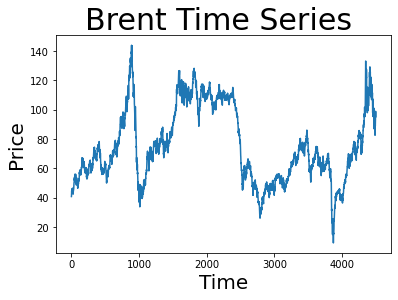

In [ ]:

df = pd.read_csv('chopped data 2.csv')
print(df.head())

plt.suptitle('Brent Time Series', fontsize='30')
plt.xlabel('Time', fontsize ='20')
plt.ylabel('Price', fontsize='20')
plt.plot(df['DCOILBRENTEU'].values)
plt.show()

This code shows how to manually find a motif assuimg a time window (m) of 90 days. This code is not really relevant for analyses. 

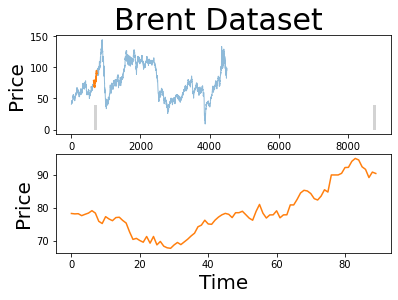

In [16]:
m = 90
fig, axs = plt.subplots(2)
plt.suptitle('Brent Dataset', fontsize='30')
axs[0].set_ylabel("Price", fontsize='20')
axs[0].plot(df['DCOILBRENTEU'], alpha=0.5, linewidth=1)
axs[0].plot(df['DCOILBRENTEU'].iloc[643:643+m])
axs[0].plot(df['DCOILBRENTEU'].iloc[8724:8724+m])
rect = Rectangle((643, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
rect = Rectangle((8724, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
axs[1].set_xlabel("Time", fontsize='20')
axs[1].set_ylabel("Price", fontsize='20')
axs[1].plot(df['DCOILBRENTEU'].values[643:643+m], color='C1')
axs[1].plot(df['DCOILBRENTEU'].values[8724:8724+m], color='C2')
plt.show()

The following piece of code uses the STUMPY library to calculate the actual matrix profile. It locates a motif and its nearest neighbor. The it calculates the eucledian distance between these 2 windows. 

The motif is located at index 2409
The nearest neighbor is located at index 2449


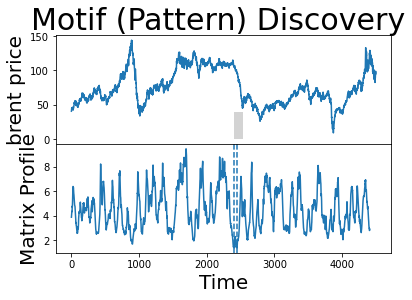

1.361348751452917


In [17]:
mp = stumpy.stump(df['DCOILBRENTEU'], m)

motif_idx = np.argsort(mp[:, 0])[0]

print(f"The motif is located at index {motif_idx}")

nearest_neighbor_idx = mp[motif_idx, 1]

print(f"The nearest neighbor is located at index {nearest_neighbor_idx}")

fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Motif (Pattern) Discovery', fontsize='30')

axs[0].plot(df['DCOILBRENTEU'].values)
axs[0].set_ylabel('brent price', fontsize='20')
rect = Rectangle((motif_idx, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
rect = Rectangle((nearest_neighbor_idx, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
axs[1].set_xlabel('Time', fontsize ='20')
axs[1].set_ylabel('Matrix Profile', fontsize='20')
axs[1].axvline(x=motif_idx, linestyle="dashed")
axs[1].axvline(x=nearest_neighbor_idx, linestyle="dashed")
axs[1].plot(mp[:, 0])
plt.show()

z_dis = mp[motif_idx, 0]
print(z_dis)


TIME SERIES CHAINS:
What are Time Series Chains?
Time series chains may be informally considered as motifs that evolve or drift in some direction over time. The figure below illustrates this. 

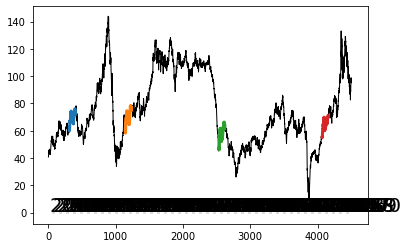

In [18]:
all_chain_set, unanchored_chain = stumpy.allc(mp[:, 2], mp[:, 3])

plt.plot(df['DCOILBRENTEU'], linewidth=1, color='black')
for i in range(unanchored_chain.shape[0]):
    y = df['DCOILBRENTEU'].iloc[unanchored_chain[i]:unanchored_chain[i]+m]
    x = y.index.values
    plt.plot(x, y, linewidth=3)
color = itertools.cycle(['white', 'gainsboro'])
for i, x in enumerate(range(0, df.shape[0], 52)):
    plt.text(x+12, 0.9, str(2004+i), color="black", fontsize=20)
    rect = Rectangle((x, -1), 52, 2.5, facecolor=next(color))
    plt.gca().add_patch(rect)

plt.show()

Here we can see the motifs that evolve over time. Keep in mind that each time the variation or volatilty is greater. 

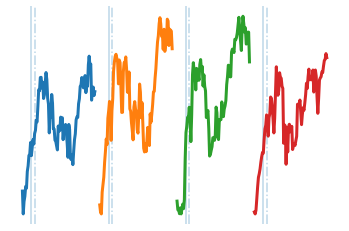

In [19]:
plt.axis('off')
for i in range(unanchored_chain.shape[0]):
    data = df['DCOILBRENTEU'].iloc[unanchored_chain[i]:unanchored_chain[i]+m].reset_index().values
    x = data[:, 0]
    y = data[:, 1]
    plt.axvline(x=x[0]-x.min()+(m+5)*i + 11, alpha=0.3)
    plt.axvline(x=x[0]-x.min()+(m+5)*i + 15, alpha=0.3, linestyle='-.')
    plt.plot(x-x.min()+(m+5)*i, y-y.min(), linewidth=3)
plt.show()

A larger window of time works better for the motif finding but a smaller window of time works better for time series chains. 